# Hybrid microstrip/co-planar waveguide bandpass filter

In this notebook, we demonstrate a hybrid microstrip/co-planar waveguide (CPW) bandpass filter designed to operate within the ultra-wideband (UWB) from 3.1-10.6 GHz. The UWB is permitted for unlicensed use in indoor and handheld devices by the Federal Communications Commission (FCC) since 2002. 

The filter is a 5-pole design. It is driven by input and output microstrip transmission lines. The coupling region between the microstrip signal line, in the top layer, and the CPW, in the bottom layer, accounts for two of the five poles. The remaining three poles come from stepwise changes in the CPW gap width and line length.  

The filter is designed by Wang et al. in the following reference:

[1] Hang Wang, Lei Zhu and W. Menzel, "Ultra-wideband bandpass filter with hybrid microstrip/CPW structure," in IEEE Microwave and Wireless Components Letters, vol. 15, no. 12, pp. 844-846, Dec. 2005, doi: 10.1109/LMWC.2005.860016.

<center><img src="./img/mccpw_render.png" width=600 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.smatrix as sm

td.config.logging_level = "ERROR"

## Building the Simulation

### General Parameters

We define the frequency range of the simulation below, which covers the bandwidth of interest. 

In [2]:
# Frequencies and bandwidth
(f_min, f_max) = (1e9, 13e9)
f0 = (f_min + f_max) / 2
freqs = np.linspace(f_min, f_max, 401)

Geometry parameters are defined below. The default length unit is microns, so we define the `mm` conversion factor for convenience. 

<center><img src="./img/mccpw_schematic.png" width=600 /></center>

In [3]:
mm = 1000  # Conversion factor from mm to micron
len_inf = 1e6  # Effective infinity

# Main dimensions
H = 0.635 * mm  # Substrate thickness
T = 0.035 * mm  # Metal thickness
W = 20 * mm  # Overall width (y)
L = 30 * mm  # Overall length (x)

# Filter dimensions
S1 = 1.1 * mm  # CPW wide gap
L1, W1 = (17.54 * mm, 0.92 * mm + 2 * S1)  # CPW negative space
L2, W2 = (16.9 * mm, 0.92 * mm)  # CPW middle strip
L3, W3 = (9.18 * mm, 0.92 * mm)  # CPW top and bottom strips

# Feed dimensions (microstrip)
FW = 0.6 * mm  # Feed width
LOV = 3.7 * mm  # Overlap length

The simulation size is defined below. 

In [4]:
# Sim size
sim_LX = 50 * mm
sim_LY = 40 * mm
sim_LZ = 20 * mm

### Medium and Structures

The substrate is made of RT-Duroid 6010 and assumed lossless. 

The metal (copper) is assumed to have constant conductivity of `60` S/um over the frequency range. The [`LossyMetalMedium`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LossyMetalMedium.html) implements a surface impedance boundary condition on the material and fields inside the material are assumed to be zero. This is most accurate when the metal thickness is larger than the skin depth. 

In [5]:
med_air = td.Medium(permittivity=1, name="Air")
med_sub = td.Medium(permittivity=10.8, name="RT-Duroid 6010")
med_metal = td.LossyMetalMedium(conductivity=60, frequency_range=(f_min, f_max), name="Lossy metal")

The structures for the simulation are defined below. First, the substrate. 

In [6]:
# Substrate
str_sub = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(L, W, H)),
    medium=med_sub,
)

The bottom metal layer is the CPW filter. We use `geom_hole` to cut out a rectangular hole in the ground plane `geom_plane`. This is done with the `-` operator, which is shorthand for a difference `ClipOperation`. Then we add three strips `geom_top_box`, `geom_mid_box`, and `geom_bot_box` to form the rest of the CPW in a single `GeometryGroup`. 

In [7]:
# Bottom plane w/ CPW filter
z_bot = -H / 2 - T / 2
geom_plane = td.Box(center=(0, 0, z_bot), size=(L, W, T))
geom_hole = td.Box(center=(0, 0, z_bot), size=(L1, W1, T))
geom_top_box = td.Box(center=(0, W1 / 2 - W3 / 2, z_bot), size=(L3, W3, T))
geom_bot_box = geom_top_box.translated(0, -W1 + W3, 0)
geom_mid_box = td.Box(center=(0, 0, z_bot), size=(L2, W2, T))
geom_bottom_plane = td.GeometryGroup(
    geometries=[
        geom_top_box,
        geom_bot_box,
        geom_mid_box,
        geom_plane - geom_hole,
    ]
)
str_bottom_plane = td.Structure(geometry=geom_bottom_plane, medium=med_metal)

The top layer consists of the microstrip signal line. In the overlap section, the line is slightly widened to match the width of the CPW signal strip.

In [8]:
# Top plane w/ microstrips
z_top = H / 2 + T / 2
str_feed_1 = td.Structure(
    geometry=td.Box(center=((-L - L2) / 4, 0, z_top), size=((L - L2) / 2, FW, T)), medium=med_metal
)
str_feed_2 = td.Structure(
    geometry=td.Box(center=((L + L2) / 4, 0, z_top), size=((L - L2) / 2, FW, T)), medium=med_metal
)
str_overlap_patch_1 = td.Structure(
    geometry=td.Box(center=(-L2 / 2 + LOV / 2, 0, z_top), size=(LOV, W2, T)), medium=med_metal
)
str_overlap_patch_2 = td.Structure(
    geometry=td.Box(center=(L2 / 2 - LOV / 2, 0, z_top), size=(LOV, W2, T)), medium=med_metal
)

Finally, we collect all the structures in a list for later reference. 

In [9]:
# Full structure list
str_list_full = [
    str_sub,
    str_bottom_plane,
    str_feed_1,
    str_feed_2,
    str_overlap_patch_1,
    str_overlap_patch_2,
]

### Grid

For layered metallic structures such as this, the [`LayerRefinementSpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html) feature can be useful to quickly add refinement to metal corners and edges. The key settings here are `min_steps_along_axis=2` and `dl=T/2` for `corner_refinement`. This ensures a good level of refinement for accurate S-parameters. 

Note that the settings chosen here favor accuracy over cost. For initial design exploration, we recommend reducing `min_steps_along_axis` to `1` and `dl=T` for much lower cost and slightly faster simulation time. 

In [10]:
# Layer refinement for top and bottom metal layers
LR1_spec = td.LayerRefinementSpec(
    center=(0, 0, z_top),
    size=(td.inf, td.inf, T),
    axis=2,
    corner_refinement=td.GridRefinement(dl=T / 2, num_cells=2),
    min_steps_along_axis=2,
)
LR2_spec = td.LayerRefinementSpec(
    center=(0, 0, z_bot),
    size=(td.inf, td.inf, T),
    axis=2,
    corner_refinement=td.GridRefinement(dl=T / 2, num_cells=2),
    min_steps_along_axis=2,
)

The rest of the simulation uses an automatic grid, with maximum grid size set by the minimum wavelength.

In [11]:
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f_max, min_steps_per_wvl=20, layer_refinement_specs=[LR1_spec, LR2_spec]
)

### Monitors

We define several field monitors for visualization purposes. 

In [12]:
# Transverse field monitor
mon_1 = td.FieldMonitor(
    center=(6.7 * mm, 0, 0),
    size=(0, td.inf, td.inf),
    freqs=[f_min, f0, f_max],
    name="field transverse",
)

# Longitudinal field monitor
mon_2 = td.FieldMonitor(
    center=(0, 0, z_top),
    size=(td.inf, td.inf, 0),
    freqs=[f_min, f0, f_max],
    name="field microstrip plane",
)
mon_3 = td.FieldMonitor(
    center=(0, 0, z_bot), size=(td.inf, td.inf, 0), freqs=[f_min, f0, f_max], name="field CPW plane"
)

### Ports

The model is excited by two 50 Ohm [lumped ports](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.LumpedPort.html), one for each microstrip line. 

In [13]:
LP1 = sm.LumpedPort(
    center=(-L / 2, 0, 0),
    size=(0, FW, H),
    voltage_axis=2,
    name="LP1",
    impedance=50,
)
LP2 = LP1.updated_copy(center=(L / 2, 0, 0), name="LP2")

### Simulation and TerminalComponentModeler

We collect all the previously defined information into a single `Simulation` object. A few notes:
* The model is surrounded by PML on all sides to absorb any radiated field. 
* The model is symmetric about the y-axis, so we set up the `symmetry` parameter accordingly. The value `1` refers to even symmetry (PMC).
* The `shutoff` (energy condition for early termination) is lowered to `1e-7` for better small signal accuracy.

In [14]:
sim = td.Simulation(
    size=(sim_LX, sim_LY, sim_LZ),
    grid_spec=grid_spec,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    structures=str_list_full,
    monitors=[mon_1, mon_2, mon_3],
    shutoff=1e-7,
    run_time=10e-9,
    symmetry=(0, 1, 0),
    plot_length_units="mm",
)

For RF simulations, we do not run the `Simulation` directly. Instead, we use the [`TerminalComponentModeler`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html). This is a wrapper object that automatically sets up a port and frequency sweep to yield the full S-parameter matrix.

In [15]:
tcm = sm.TerminalComponentModeler(
    simulation=sim,
    ports=[LP1, LP2],
    freqs=freqs,
    path_dir="data",
    verbose=True,
)

### Visualization

Before running, it is a good idea to plot the simulation to check the geometry and grid.

In [16]:
sim.plot_3d()

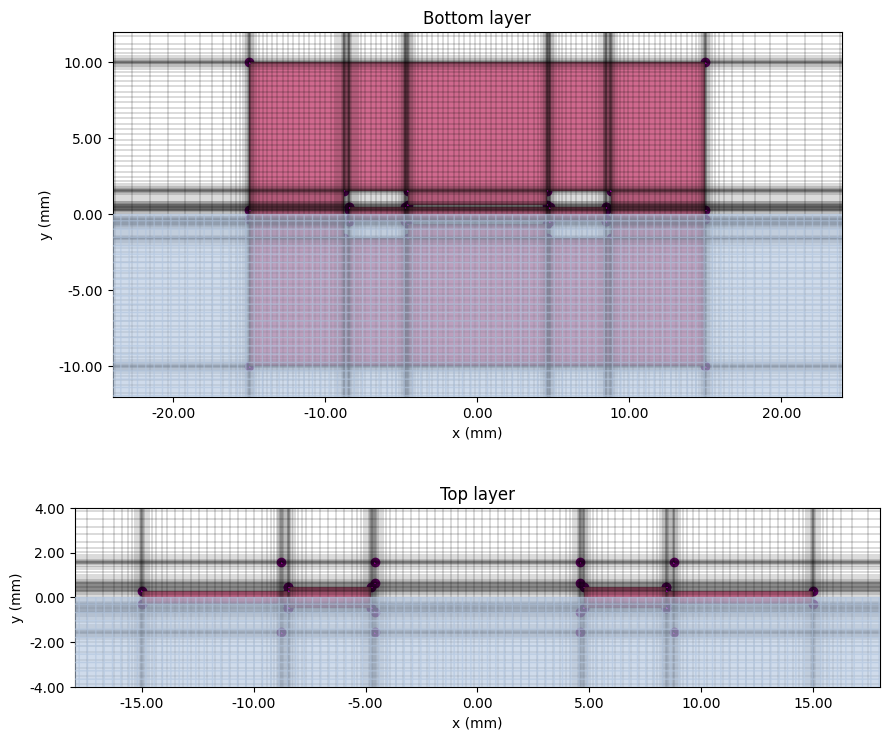

In [17]:
# Plot top and bottom planes
fig, ax = plt.subplots(2, 1, figsize=(9, 8), tight_layout=True)
sim.plot_grid(z=z_bot, ax=ax[0])
sim.plot(z=z_bot, ax=ax[0], monitor_alpha=0, hlim=(-0.8 * L, 0.8 * L), vlim=(-0.6 * W, 0.6 * W))
ax[0].set_title("Bottom layer")
sim.plot_grid(z=z_top, ax=ax[1])
sim.plot(z=z_top, ax=ax[1], monitor_alpha=0, hlim=(-0.6 * L, 0.6 * L), vlim=(-0.2 * W, 0.2 * W))
ax[1].set_title("Top layer")
plt.show()

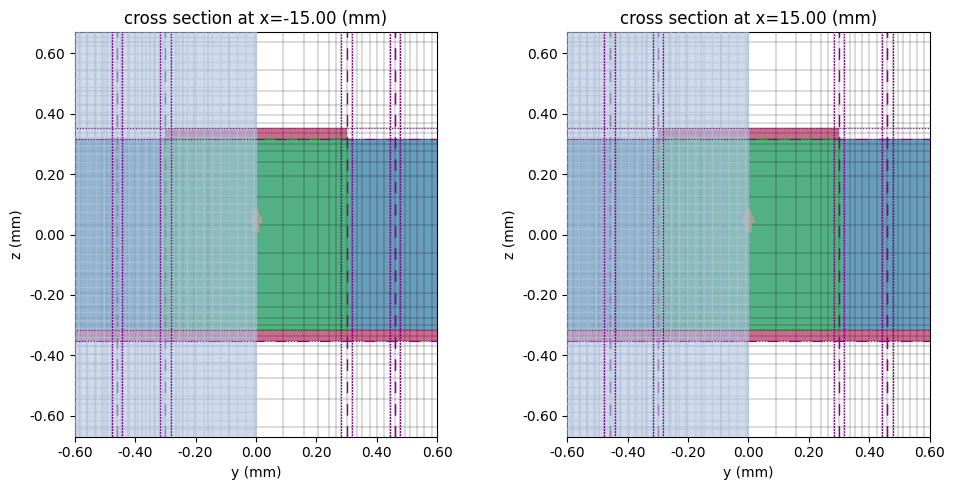

In [18]:
# Plot lumped ports
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
tcm.plot_sim(x=-L / 2, ax=ax[0], monitor_alpha=0)
sim.plot_grid(x=-L / 2, ax=ax[0], hlim=(-FW, FW), vlim=(2 * z_bot, 2 * z_top))
tcm.plot_sim(x=L / 2, ax=ax[1], monitor_alpha=0)
sim.plot_grid(x=L / 2, ax=ax[1], hlim=(-FW, FW), vlim=(2 * z_bot, 2 * z_top))
plt.show()

## Run Simulation

Before running, we might like to estimate the cost of the simulation. 

In [19]:
_ = tcm.batch.estimate_cost()

11:42:09 EDT Maximum FlexCredit cost: 0.820 for the whole batch.

The simulation is run by calling the `run()` method of `TerminalComponentModeler`. After the simulation is complete, the method returns the S-parameter matrix automatically. 

In [20]:
s_matrix = tcm.run()

Output()

             Started working on Batch containing 2 tasks.

11:42:11 EDT Maximum FlexCredit cost: 0.820 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

             Batch complete.

Output()

The real cost of the simulation is reported below. 

In [21]:
_ = tcm.batch.real_cost()

11:42:19 EDT Total billed flex credit cost: 0.722.

## Results

### Field Profiles

First, let us examine the field profiles. The field monitor data can be accessed from the `BatchData` associated with the `TerminalComponentModeler`. We use `tcm.batch_data` to reference the batch data, then the `'smatrix_LP1'` key to access the simulation data corresponding to the port `LP1` excitation. 

In [22]:
sim_data = tcm.batch_data["smatrix_LP1"]

The field profiles are plotted below. 

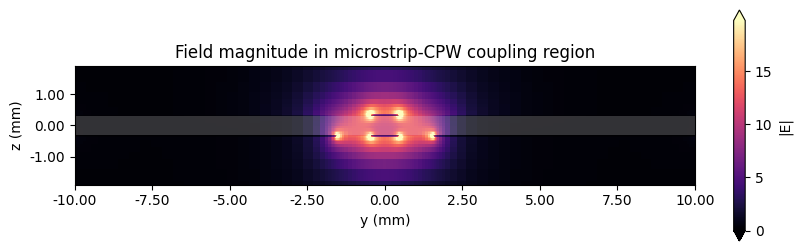

In [23]:
# Transverse field
fig, ax = plt.subplots(figsize=(10, 3))
sim_data.plot_field("field transverse", field_name="E", val="abs", scale="lin", f=f0, ax=ax)
ax.set_xlim(-W / 2, W / 2)
ax.set_ylim(-3 * H, 3 * H)
ax.set_title("Field magnitude in microstrip-CPW coupling region")
plt.show()

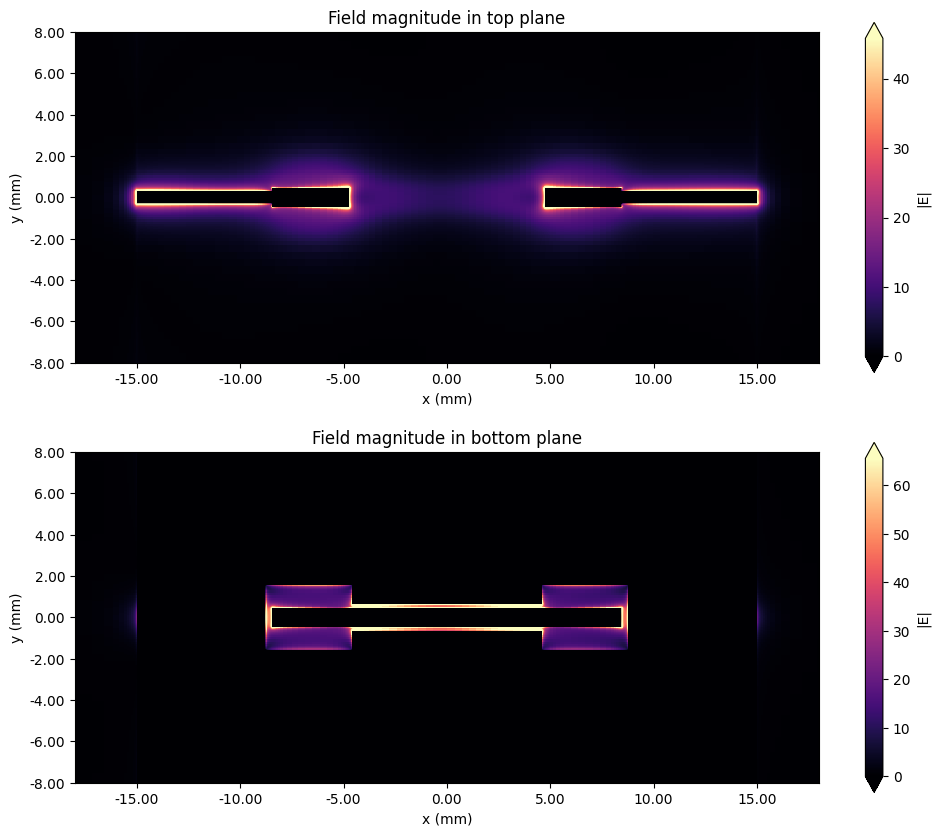

In [24]:
# In-plane fields
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sim_data.plot_field("field microstrip plane", field_name="E", val="abs", f=f0, ax=ax[0])
sim_data.plot_field("field CPW plane", field_name="E", val="abs", f=f0, ax=ax[1])
for axis in ax:
    axis.set_xlim(-0.6 * L, 0.6 * L)
    axis.set_ylim(-0.4 * W, 0.4 * W)
ax[0].set_title("Field magnitude in top plane")
ax[1].set_title("Field magnitude in bottom plane")
plt.show()

### S-parameters and Group Delay

The desired S-parameter $S_{ij}$ can be extracted from the full `s_matrix` using the `port_in` and `port_out` indices. Since the default phase convention in the solver is the physics convention $e^{-i\omega t}$, we apply `np.conjugate` to convert the S-parameters to the engineering convention $e^{j\omega t}$. 

In [25]:
S11 = np.conjugate(s_matrix.isel(port_in=0, port_out=0))
S21 = np.conjugate(s_matrix.isel(port_in=0, port_out=1))
S11dB = 20 * np.log10(np.abs(S11))
S21dB = 20 * np.log10(np.abs(S21))

For benchmarking purposes, we import comparison data from an identical model run using a commercial FEM solver. 

In [26]:
f_fem, S11dB_fem, S21dB_fem = np.genfromtxt(
    fname="./misc/mccpw_fem.csv", delimiter=",", unpack=True
)

The insertion and return losses are plotted below. We observe a good match with the commercial FEM benchmark. 

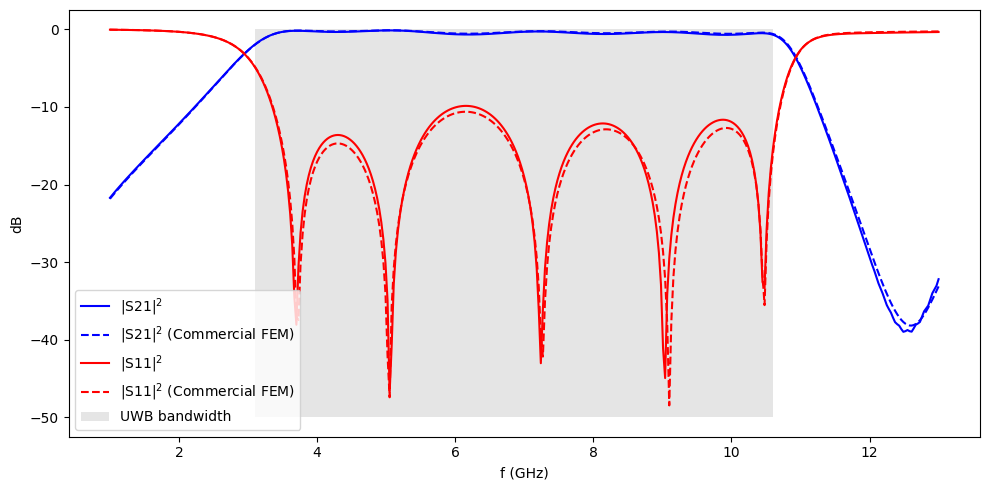

In [27]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs / 1e9, S21dB, "b", label="|S21|$^2$")
ax.plot(f_fem, S21dB_fem, "b--", label="|S21|$^2$ (Commercial FEM)")
ax.plot(freqs / 1e9, S11dB, "r", label="|S11|$^2$")
ax.plot(f_fem, S11dB_fem, "r--", label="|S11|$^2$ (Commercial FEM)")
ax.add_patch(plt.Rectangle((3.1, 0), 10.6 - 3.1, -50, fc="gray", alpha=0.2, label="UWB bandwidth"))
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
plt.show()

The filter exhibits a passband that is almost flat and a maximum S11 of approximately -10dB throughout the UWB passband. This is also in good agreement with the experimental results reported in the reference paper. 

We can also calculate the group delay
$$
  \tau_g(\omega) \simeq -\frac{\Delta\phi}{\Delta\omega}
$$
where $\phi$ is the phase of S21 and $\omega = 2\pi f$. 

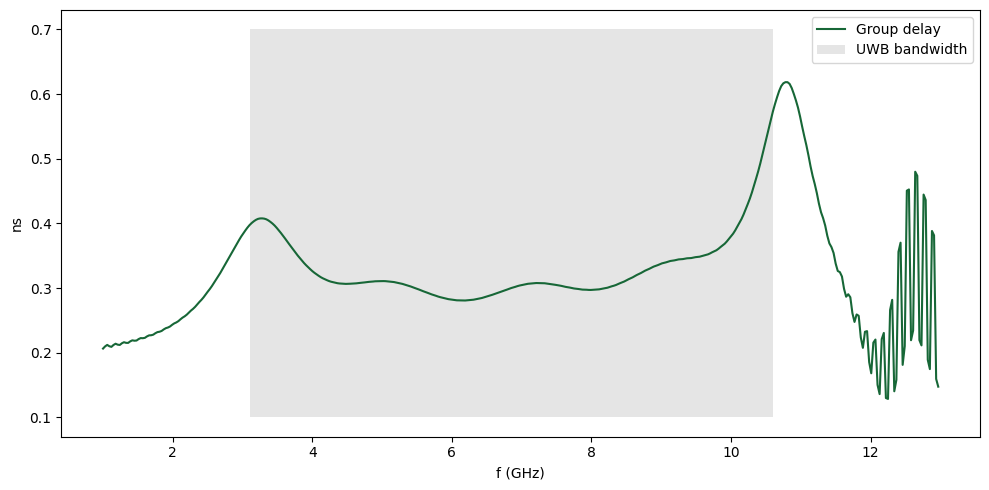

In [28]:
# Calculating group delay
df = freqs[1] - freqs[0]
group_delay_S21 = -np.diff(np.unwrap(np.angle(S21))) / (2 * np.pi * df) * 1e9

fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs[:-1] / 1e9, group_delay_S21, label="Group delay")
ax.add_patch(
    plt.Rectangle((3.1, 0.1), 10.6 - 3.1, 0.6, fc="gray", alpha=0.2, label="UWB bandwidth")
)
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("ns")
plt.show()

We observe that the group delay varies between 0.3 to 0.6 ns in the UWB passband. This is close to the 0.46 to 0.74 ns range reported in experimental measurements in the paper. In either case, the maximum variation in group delay is less than 0.3 ns. 

Outside the UWB passband, we can observe oscillatory behaviour near the limits of the simulation bandwidth. This is due to the small value of |S21|. We can reduce this oscillation by further lowering the `shutoff` value in `Simulation` and extending `run_time`. That said, for this demonstration, it is not a priority since we are primarily interested in behavior within the UWB passband. 